error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


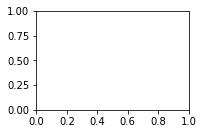

In [1]:
from re import I
#from turtle import color
import cv2, platform,time
from cv2 import waitKey
from matplotlib import markers
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from PIL import Image 
plt.figure(1)

I=cv2.imread('data/gdb_benin.jpg',0)#.astype(float)
plt.subplot(221)
plt.imshow(cv2.cvtColor(I,cv2.COLOR_BGR2RGB))
ret,thresh1=cv2.threshold(I,125,255,cv2.THRESH_BINARY)
plt.subplot(222)
plt.imshow(cv2.cvtColor(thresh1,cv2.COLOR_BGR2RGB))

S=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))

I_open=cv2.dilate(cv2.erode(thresh1,S),S)
plt.subplot(223)
plt.imshow(cv2.cvtColor(I_open,cv2.COLOR_BGR2RGB))
TYPE=type(I)

IMAGE=I_open.astype(TYPE)
IMAGE2=I_open
#partie snake

Lx, Ly = np.shape(IMAGE2)
#
#plt.imshow(IMAGE,'gray')
#plt.title('Image de départ')


#plt.imshow(ImNoise, 'gray')
#plt.title('Image bruitée')
#plt.show()
#
#plt.imshow(ImNoiseFilter, 'gray')
#plt.title('Image Bruitée puis filtrée')
#plt.show()

# %%
###Creation du snake###
centre=[int(Ly/2),int(Lx/2)]
rayon=min(int((Lx-5)/2), int((Ly-5)/2))/3

K = 1000
snakeX = []
snakeY = []
pas = (2*np.pi)/K
for i in range(K):
    theta = i*pas
    snakeX = np.append(snakeX, int(centre[0] + rayon * np.cos(theta)))
    snakeY = np.append(snakeY, int(centre[1] + rayon * np.sin(theta)))
# print(snakeX.shape)
c = np.zeros((K,1,2))
# print(c.shape)
c[:,:,0] = snakeX.reshape((K,1))
c[:,:,1] = snakeY.reshape((K,1))
#c = np.concatenate((snakeX.reshape((K,1)),snakeY.reshape((K,1))),axis=2)
# print(c[:,0,0])
contour_list = []
contour_list.append(c.astype(int))
snake = cv2.drawContours(image=cv2.cvtColor(IMAGE2, cv2.COLOR_GRAY2BGR),contours=contour_list, contourIdx=-1, color=(255, 0, 0), thickness=1,lineType=cv2.LINE_AA)
plt.imshow(snake)
plt.show()



# %%
### Parametres ###
alpha = 3
beta = 0.1
gamma = 1.2

# %% [markdown]
# #### On défini les matrices pour les opérateurs
# La matrice `D1` correspond à une approximation de la dérivée par différence finies. La matrice `D2` correspond à une dérivée seconde et `D4` à une dérivée quatrième.

# %%
###Creation de D2, D4, D et A###
Id = np.identity(K)
D1 = np.roll(Id, 1, axis=-1) + Id*(0) - np.roll(Id,-1, axis=1)
D2 = np.roll(Id, -1, axis=1) + Id*(-2) + np.roll(Id,1, axis=1)
D4 = (np.roll(Id, -1, axis=1) + np.roll(Id,1, axis=1))*-4 + (np.roll(Id, -2, axis=1) + np.roll(Id,2, axis=1)) + Id*(6)
D = alpha*D2 - beta*D4
A = np.linalg.inv(Id - D)
#logging.info('Operators generated')

# %%
# Le Gradient
[Gx,Gy] = np.gradient(IMAGE2.astype(float))
plt.figure()
plt.subplot(1,3,1)
plt.imshow(Gx)
plt.subplot(1,3,2)
plt.imshow(Gy)
Gx_norm = Gx/np.max(Gx)
Gy_norm = Gy/np.max(Gy)
NormeGrad = np.square(Gx_norm)+np.square(Gy_norm)

plt.subplot(1,3,3)
plt.imshow(NormeGrad,'gray')
plt.show()
#NormeGrad = NormeGrad*20
# Gradient de la norme 
[GGx,GGy] = np.gradient(NormeGrad.astype(float))

#logging.info('Gradient computed')

# %%
# Algo ITERATIF
limite = 3000
iteration = 0
nbfigure = 1

Energie = list()
energie_ela = list()
energie_courb = list()
enregie_ext = list()

MEMORY = []
Xn = snakeX
Yn = snakeY
MEMORY.append([Xn,Yn])
#logging.info('Algorithm initialized')

# %%
flag = True
while flag or (iteration < limite):
    # itération du SNAKE
    Xn1 = np.dot(A, Xn + gamma*GGx[Yn.astype(int),Xn.astype(int)] )
    Yn1 = np.dot(A, Yn + gamma*GGy[Yn.astype(int),Xn.astype(int)] )     
    Xn = Xn1
    Yn = Yn1   
    MEMORY.append([Xn,Yn])
    # Calcul de l'energie
    ELA = 0
    COURB  = 0
    EXT = 0
    Xnprime = np.dot(D1, Xn)
    Ynprime = np.dot(D1, Yn)
    Xnseconde = np.dot(D2, Xn)
    Ynseconde = np.dot(D2, Yn)
    for k in range(K):
        ELA += alpha*0.5*np.sqrt(np.square(Xnprime[k]) + np.square(Ynprime[k]))
        COURB += beta*0.5*np.sqrt(np.square(Xnseconde[k]) + np.square(Ynseconde[k]))
        EXT -= np.square(NormeGrad[int(Yn[k]),int(Xn[k])])
    Energie.append(ELA+COURB+EXT)
    enregie_ext.append(EXT)
    energie_courb.append(COURB)
    energie_ela.append(ELA)

    # Flag de sortie
    # 
    # TODO : 
    #   Calculer energie sur fenetre glissante pour flag de sortie afin de lisser les variations
    # if iteration > 200:
    #     nbSplit = iteration // 50
    #     EnerSplit = np.split(Energie, nbSplit)
    #     e1 = EnerSplit[-1]
    #     e2 = EnerSplit[-2]
    if (abs(Energie[iteration]-Energie[iteration-1])/Energie[iteration]<10):
        flag = False

    
    # Affichage
    if iteration % 10 == 0:
        c = np.zeros((K,1,2))
        c[:,:,0] = Xn1.reshape((K,1))
        c[:,:,1] = Yn1.reshape((K,1))
        contour_list = []
        contour_list.append(c.astype(int))
        snake = cv2.drawContours(image=cv2.cvtColor(IMAGE2, cv2.COLOR_GRAY2BGR),contours=contour_list, contourIdx=-1, color=(255, 0, 0), thickness=1,lineType=cv2.LINE_AA)
        # Sauvegarde des images pour faire l'animation
        #filename = f"img_{iteration:05d}.png"
        
        #cv2.imwrite(filename, snake)

    # Fin de la boucle
    iteration += 1


# %%
c = np.zeros((K,1,2))
print(c.shape)
c[:,:,0] = Xn1.reshape((K,1))
c[:,:,1] = Yn1.reshape((K,1))
contour_list = []
contour_list.append(c.astype(int))
snake = cv2.drawContours(image=cv2.cvtColor(IMAGE2, cv2.COLOR_GRAY2BGR),contours=contour_list, contourIdx=-1, color=(255, 0, 0), thickness=1,lineType=cv2.LINE_AA)
plt.imshow(snake)
cv2.imwrite("itération finale.png",snake)
plt.title('Itération finale')

# %% [markdown]
# ####  Affichage de la fonction de coût

# %%
# plt.plot(Energie)
# plt.title('Fonction de coût')
# plt.show()

# # %%
# plt.plot(energie_ela)
# plt.title('Energie élastique')
# plt.show()

# # %%
# plt.plot(energie_courb)
# plt.title('Energie de courbure')
# plt.show()

# # %%
# plt.plot(enregie_ext)
# plt.title('Energie externe')
# plt.show()


for i in range(len(Xn)):
    if (i<250):
        color= "red"
    elif (i>=250 and i < 500):
        color="green"
    elif (i>=500 and i<750):
        color="blue"
    elif (i>=750 and i<1000):
        color="yellow"
    plt.plot(Xn[i],-Yn[i],marker="o",color=color)
    #plt.plot(Xn[200],Yn[200],marker="o",color)
    #plt.plot(Xn[700],Yn[700],marker="o",color)
    #plt.plot(Xn[900],Yn[900],marker="o",color)
plt.title('Energie externe')
plt.show()
#print(Xn)
#print(Yn)

A=[Xn[140],-Yn[140]]
B=[Xn[200],-Yn[200]]
C=[Xn[700],-Yn[700]]
D=[Xn[900],-Yn[900]]
plt.plot(Xn[140],-Yn[140],marker="o",color="red")
plt.plot(Xn[200],-Yn[200],marker="o",color="green")
plt.plot(Xn[700],-Yn[700],marker="o",color="blue")
plt.plot(Xn[900],-Yn[900],marker="o",color="yellow")
plt.plot([A[0],C[0]],[A[1],C[1]],color="red")
plt.plot([B[0],D[0]],[B[1],D[1]],color="blue")

# plt.show()

print("size Iopen : " +str(np.shape(I_open)))

src_img=I>=125

src_img=src_img.astype(np.uint8)
src_img=src_img*255
#cv2.cvtColor(I_open,cv2.COLOR_RGB2GRAY)
#color_img = cv2.cvtColor(src_img,cv2.COLOR_RGB2GRAY)
color_img=src_img
print("size color_img : " + str(np.shape(color_img)))
rows=src_img.shape[0]
circles_img = cv2.HoughCircles(src_img,cv2.HOUGH_GRADIENT,1,rows,param1=250,param2=10,minRadius=0,maxRadius=0)
circles_img = np.uint16(np.around(circles_img))
print(circles_img)
for i in circles_img[0,:]:
    cv2.circle(color_img,(i[0],i[1]),i[2],(0,255,0),2)
    cv2.circle(color_img,(i[0],i[1]),2,(0,0,255),3)
plt.subplot(224)
#plt.imshow('Original Image',src_img)
plt.imshow(cv2.cvtColor(src_img,cv2.COLOR_BGR2RGB))
#plt.imshow('Detected Circles',color_img)
plt.imshow(cv2.cvtColor(color_img,cv2.COLOR_BGR2RGB))

plt.figure(3)
plt.imshow(I)
plt.plot(circles_img[0,0,0],circles_img[0,0,1],marker="o",color="red")



print(min(Xn),min(Yn))
print(max(Xn),max(Yn))

plt.figure(4)
#cropped=I_open.crop((min(Xn),min(Yn),max(Xn),max(Yn)))
cropped=I_open[[min(Xn).astype(int),min(Yn).astype(int)],[max(Xn).astype(int),max(Yn).astype(int)]] #((min(Xn),min(Yn),max(Xn),max(Yn)))
plt.imshow(cropped)
plt.show()
